In [1]:
import os
from pathlib import Path
import pandas as pd
import time

from viz import training_progress_static, param_decay

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
OUTPUTS_DIR = Path('outputs')

In [3]:
!ls outputs

dqn on lander @ 06.05 10.17-0  dqnp on lander @ 06.05 10.14-1
dqn on lander @ 06.05 10.17-1  dqnp on lander @ 06.05 10.16-0
dqn on lander @ 06.05 10.17-2  dqnp on lander @ 06.05 10.16-1
dqn on lander @ 06.05 10.17-3  dqnp on lander @ 06.05 10.16-2
dqn on lander @ 06.05 22.35-0  dqnp on lander @ 06.05 10.16-3
dqn on lander @ 06.05 22.35-1  dqnp on lander @ 06.05 10.16-4
dqn on lander @ 06.05 22.35-2  dqnp on lander @ 06.05 10.16-5
dqn on lander @ 27.04 09.34-0  dqnp on lander @ 06.05 10.16-6
dqn on lander @ 27.04 09.34-1  dqnp on lander @ 06.05 10.16-7
dqn on lander @ 27.04 09.34-2  dqnp on lander @ 06.05 22.40-0
dqn on lander @ 27.04 09.34-3  dqnp on lander @ 06.05 22.40-1
dqn on lander @ 27.04 10.35-0  dqnp on lander @ 06.05 22.40-2
dqn on lander @ 27.04 10.35-1  dqnp on lander @ 06.05 22.40-3
dqn on lander @ 27.04 10.35-2  dqnp on lander @ 06.05 22.40-4
dqn on lander @ 27.04 10.35-3  dqnp on lander @ 28.04 16.51-0
dqn on lander @ 27.04 11.45-0  dqnp on lander @ 28.04 16.51-1
dqn on l

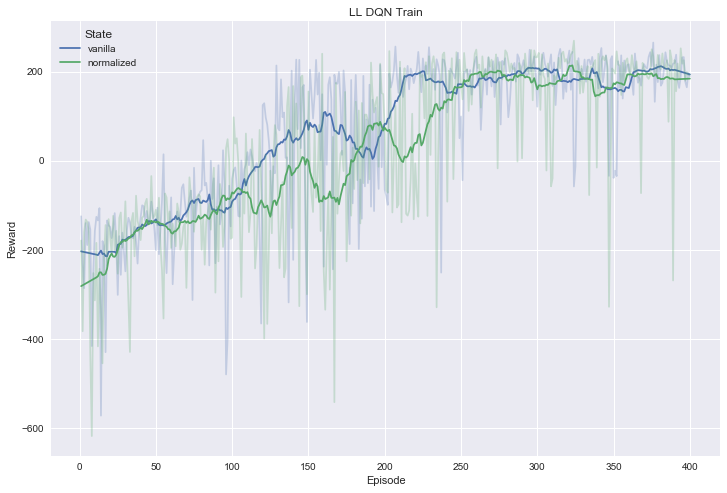

In [6]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 09.34-3/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 27.04 11.45-2/train.csv'),
], [20] * 2, ['vanilla', 'normalized'])

plt.title('LL DQN Train')
plt.legend(title='State')
plt.show()

may 6 early: dqn & dqnp with constant lr, anneal exploration over 150 episodes

very noisy: reach 0 reward after around 200 episodes, then don't improve at all

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


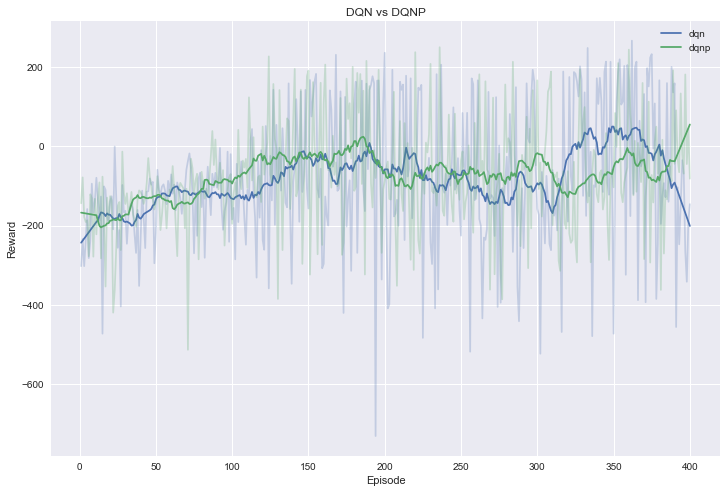

In [6]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 06.05 10.17-3/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqnp on lander @ 06.05 10.16-1/train.csv'),
], [20] * 2, ['dqn', 'dqnp'])

plt.title('DQN vs DQNP')
plt.legend()
plt.show()

may 6 late: dqn with constant lr, constant exploration

dqnp with decaying lr, annealed exploration

/Users/Stefan/.virtualenvs/rl/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


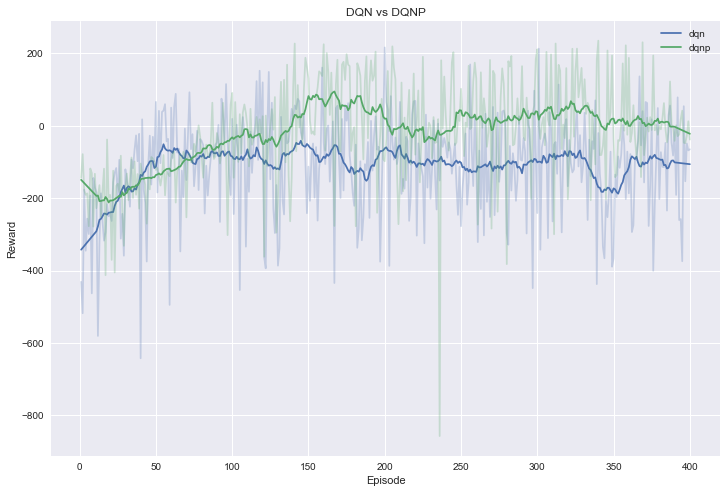

In [4]:
plt.figure(figsize=(12, 8))
training_progress_static([
    pd.read_csv(OUTPUTS_DIR / f'dqn on lander @ 06.05 22.35-1/train.csv'),
    pd.read_csv(OUTPUTS_DIR / f'dqnp on lander @ 06.05 22.40-1/train.csv'),
], [20] * 2, ['dqn', 'dqnp'])

plt.title('DQN vs DQNP')
plt.legend()
plt.show()

takes ~20 min for dqn, about ~30min for dqnp

In [ ]:
run_files = [f'lander-{a}-observed-progress.csv' for a in ['vanilla', 'extended', 'dqn', 'dqnp']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [10, 10, 10, 5], ['QL', 'QL+', 'DQN', 'DQN+'])
plt.ylim(-700, 50)
plt.title('LunarLander')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/lander-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

In [ ]:
run_files = [f'pole-{a}-observed-progress.csv' for a in ['vanilla', 'extended']]
dfs = [pd.read_csv(OUTPUTS_DIR / f) for f in run_files]

# keep best seed
dfs = [df[df.seed == df.groupby('seed').reward.max().sort_values().index[-1]] for df in dfs]

plt.figure(figsize=(10, 6))
training_progress_static(dfs, [5, 5], ['QL', 'QL+'])
plt.title('CartPole')

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/pole-comparison.{fmt}', format='png', bbox_inches='tight')
    
plt.show()

---

In [ ]:
run_name = 'lander-extended-observed'

In [ ]:
progress_df = pd.read_csv(OUTPUTS_DIR / (run_name + '-progress.csv'), index_col=0)

In [ ]:
progress_df = progress_df[progress_df.seed.isin([9, 8, 3])]

In [ ]:
plt.figure(figsize=(10, 6))
training_progress_static(progress_df, window_size=15)
plt.ylim(-400, 0)

for fmt in ['pdf', 'png']:
    plt.savefig(f'figures/{run_name}.{fmt}', format='png', bbox_inches='tight')

---

In [ ]:
config_fields = ['env', 'agent', 'state']

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'runs.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_runs = pd.concat(dfs)

In [ ]:
dfs = []

for fname in os.listdir(OUTPUTS_DIR):
    [*config, kind] = fname.split('-')
    if kind != 'progress.csv':
        continue

    df = pd.read_csv(OUTPUTS_DIR / fname, index_col=0)
    for name, value in zip(config_fields, config):
        df[name] = value
    
    dfs.append(df)
    
all_prog = pd.concat(dfs)

In [ ]:
# usual time
all_runs[all_runs.state == 'observed'].pivot_table(
    index='agent',
    columns='env',
    values='time',
    aggfunc='median',
).applymap(lambda s: time.strftime("%H:%M:%S", time.gmtime(s)))

In [ ]:
# most reward
all_prog[all_prog.env == 'lander'].pivot_table(
    index='agent',
    columns='env',
    values='reward',
    aggfunc='max',
)

In [ ]:
# usual convergence
all_prog[all_prog.env == 'pole'].pivot_table(
    index='agent',
    columns='env',
    values='episode',
    aggfunc='median',
)

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'vanilla') & (all_prog.episode > 45_000)].groupby('seed').reward.describe()

In [ ]:
all_prog[(all_prog.env == 'lander') & (all_prog.agent == 'extended') & (all_prog.episode > 95_000)].groupby('seed').reward.describe()

---

(0.0005, 0.005)

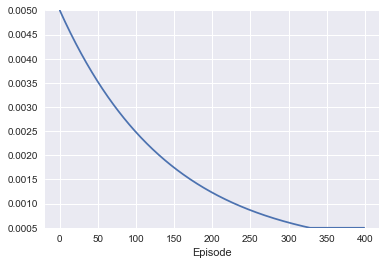

In [21]:
param_decay(400, .005, .993, .0005)
plt.ylim(.0005, .005)

In [1]:
!pip list

Package               Version     Location                    
--------------------- ----------- ----------------------------
absl-py               0.1.13      
appnope               0.1.0       
astor                 0.6.2       
backcall              0.1.0       
bayesian-optimization 0.6.0       
bleach                1.5.0       
Box2D-kengz           2.3.3       
certifi               2018.1.18   
chardet               3.0.4       
cycler                0.10.0      
dataclasses           0.5         
decorator             4.2.1       
dill                  0.2.7.1     
entrypoints           0.2.3       
future                0.16.0      
gast                  0.2.0       
GPy                   1.9.2       
GPyOpt                1.2.1       /Users/Stefan/Desktop/GPyOpt
grpcio                1.10.0      
gym                   0.10.4      
h5py                  2.7.1       
html5lib              0.9999999   
idna                  2.6         
ipykernel             4.8.2       
ipytho